In [1]:
import datacube

# from dea_tools.dask import create_dask_gateway_cluster
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import rgb
from dea_tools.plotting import display_map

from datacube.utils.cog import write_cog
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
client = create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:34277 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 62 Memory: 512.40 GB


In [3]:
dc = datacube.Datacube(app="07_Parallel_processing_with_Dask")

In [ ]:
y, x =  -19.9934, 119.7184
x_buffer = 0.7
y_buffer = 0.1

query = dict(product=['ga_ls7e_ard_3'],  # , 'ga_ls8c_ard_3'
             x=(x - x_buffer, x + x_buffer),  
             y=(y - y_buffer, y + y_buffer),
             output_crs='EPSG:3577',
             resolution=(-30, 30),
             time=("2005", "2005"))

display_map(x=query['x'], y=query['y'])

In [4]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geopolygon = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4) 

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [35]:
query = dict(product=['s2a_ard_granule', 's2b_ard_granule'],  # , 'ga_ls8c_ard_3'
             geopolygon=geopolygon,
#              x=(x - x_buffer, x + x_buffer),  
#              y=(y - y_buffer, y + y_buffer),
             output_crs='EPSG:3577',
             resolution=(-20, 20),
             time=("2020", "2020"))

In [ ]:
# # Extract boolean mask and add new mask as nodata pixels
# import odc.algo
# mask = odc.algo.enum_to_bool(lazy_data.fmask, 
#                              categories=['nodata'])
# lazy_data = odc.algo.erase_bad(lazy_data.fmask == 1, mask)


# lazy_data = odc.algo.to_float(lazy_data)
# (lazy_data.fmask == 4)

# lazy_data.fmask.persist()

In [36]:
lazy_data = dc.load(**query,
                    measurements=['fmask'],
                    dask_chunks={"time": 1, "x": 2048, "y": 2048},
                    group_by='solar_day')

valid_data = lazy_data.fmask != 0
lazy_data['clouds'] = lazy_data.fmask == 2  # odc.algo.mask_cleanup(mask=lazy_data.fmask == 2, mask_filters=[('opening', 20)])
lazy_data['shadow'] = lazy_data.fmask == 3
lazy_data['snow'] = lazy_data.fmask == 4
lazy_data = lazy_data.where(valid_data).drop('fmask')

lazy_data_mean = lazy_data.mean(dim='time')
lazy_data_mean['valid'] = valid_data.mean(dim='time')

lazy_data_mean.load()

<xarray.Dataset>
Dimensions:      (y: 19099, x: 30271)
Coordinates:
  * y            (y) float64 -1.569e+06 -1.569e+06 ... -1.951e+06 -1.951e+06
  * x            (x) float64 3.516e+05 3.516e+05 3.516e+05 ... 9.57e+05 9.57e+05
    spatial_ref  int32 3577
Data variables:
    clouds       (y, x) float64 0.2113 0.2113 0.2113 ... 0.1831 0.1831 0.1831
    shadow       (y, x) float64 0.07042 0.07042 0.07042 ... 0.02817 0.02817
    snow         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    valid        (y, x) float64 0.2518 0.2518 0.2518 ... 0.2518 0.2518 0.2518

<AxesSubplot:title={'center':'spatial_ref = 3577'}, xlabel='x [metre]', ylabel='y [metre]'>

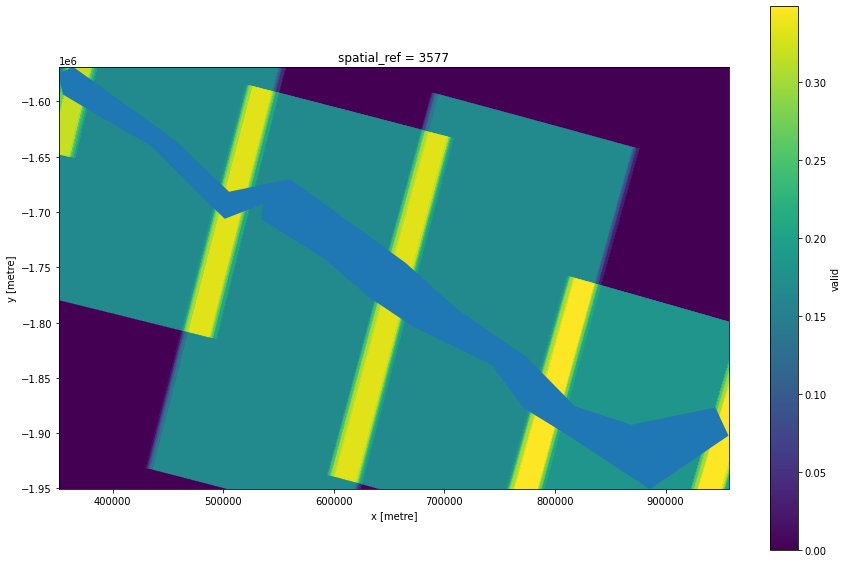

In [8]:
lazy_data_mean.valid.plot.imshow(size=10)
gpd.GeoSeries(geopolygon.geom, crs='EPSG:4326').to_crs('EPSG:3577').plot(ax=plt.gca(), edgecolor='red', color='None')

<AxesSubplot:title={'center':'spatial_ref = 3577'}, xlabel='x [metre]', ylabel='y [metre]'>

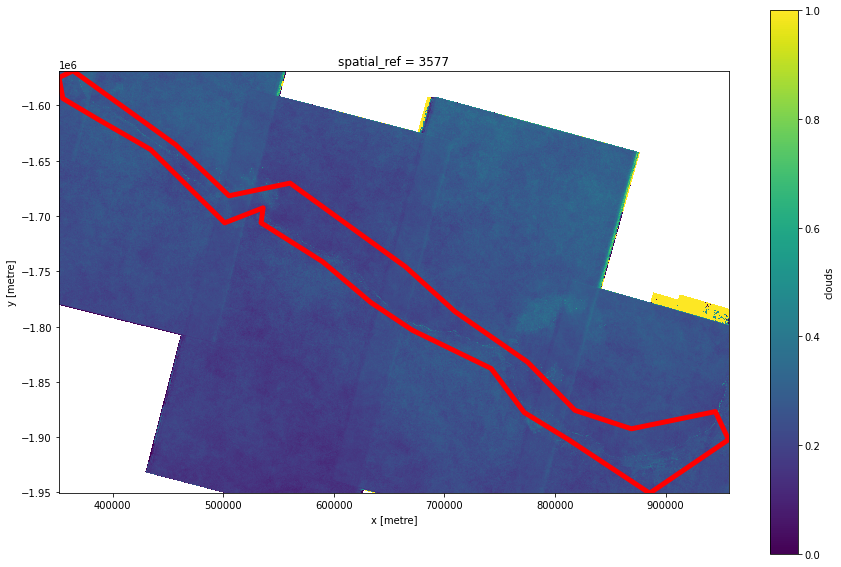

In [25]:
lazy_data_mean.clouds.plot.imshow(size=10)
gpd.GeoSeries(geopolygon.geom, crs='EPSG:4326').to_crs('EPSG:3577').plot(ax=plt.gca(), edgecolor='red', color='None', linewidth=5)

In [ ]:
lazy_data_mean.snow.plot.imshow(size=10, vmax=0.3)

In [ ]:
lazy_data_mean.shadow.plot(size=10, vmax=0.3)

In [37]:
import numpy as np

for i in lazy_data_mean:
    
    print(i)
    write_cog((lazy_data_mean[i] * 100).astype(np.int8), 
              f's2_{i}.tif', 
              overwrite=True, 
              overview_levels=[16, 32])

clouds
shadow
snow
valid
